<a href="https://colab.research.google.com/github/SinSham/Sentiment-Analysis-Project/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk # natural language toolkit
import csv

df = pd.read_csv('/content/Reviews.csv', quoting=csv.QUOTE_ALL, error_bad_lines=False)


<ipython-input-3-9be4eb66d826>:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/Reviews.csv', quoting=csv.QUOTE_ALL, error_bad_lines=False)


In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
print(df.shape)

(61946, 10)


In [6]:
df = df.head(500)

In [7]:
print(df.shape)

(500, 10)


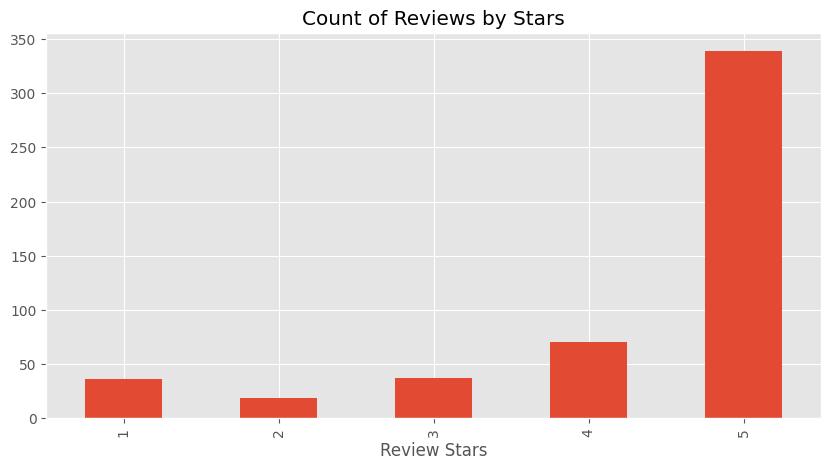

In [8]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

res = { }
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df, how='left')

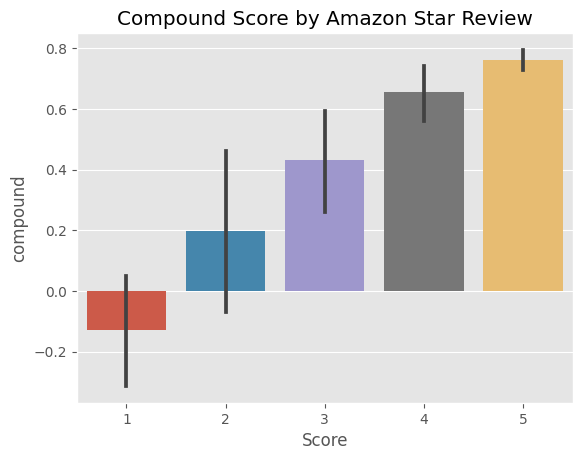

In [11]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

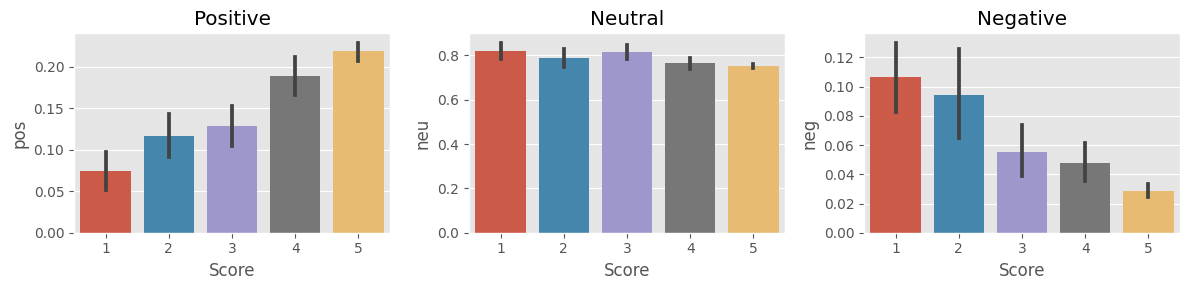

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [13]:
!pip install transformers

In [14]:
!pip install scipy


In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict={
      'roberta_neg':scores[0],
      'roberta_neu':scores[1],
      'roberta_pos':scores[2]
  }

  return scores_dict

In [17]:
res = { }
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f"vader_{key}"] = value

    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result, **roberta_result}
    res[myid] = both
  except RuntimeError :
    print(f'Broke for id {myid}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [18]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')

In [19]:
results_df

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.010578,0.038816,0.950606,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.716768,0.271225,0.012007,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.005176,0.077858,0.916966,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002919,0.047125,0.949957,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.004527,0.009283,0.986190,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,496,0.000,0.554,0.446,0.9725,0.003676,0.012186,0.984138,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
494,497,0.059,0.799,0.142,0.7833,0.006778,0.024209,0.969013,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
495,498,0.025,0.762,0.212,0.9848,0.008474,0.081599,0.909927,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
496,499,0.041,0.904,0.055,0.1280,0.796346,0.178151,0.025503,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."
